In [37]:
# Surpress warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers

In [35]:
#Global variables
IMG_SIZE = 224

In [3]:
# First lets check if the dataset exits
datasets_list = tfds.list_builders()
print("huggingface:cats_vs_dogs" in datasets_list)

True


In [39]:
# Now import the "cats_vs_dogs" dataset from tensorflow datasets
(train_data, val_data), ds_info = tfds.load("cats_vs_dogs",
                                             split = ('train[:80%]', 'train[80%:]'),
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)
print(train_data)
print(val_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [40]:
# Check what are the classes names (in this case we knew from the start it was cats and dogs)
class_names = ds_info.features["label"].names
print(class_names)

['cat', 'dog']


In [42]:
# Here we analyse a single sample from the train_data to understand the type of data we are dealing with
sample = train_data.take(1)
image, label = next(iter(sample))

print(f"Image shape: {image.shape};   Label: {label.numpy()};   Label (str format): {class_names[label.numpy()]}")
print(f"Image dtype: {image.dtype};   Label dtype: {label.dtype}")
print(f"Image min value: {tf.reduce_min(image).numpy()};   Image max value: {tf.reduce_max(image).numpy()}")
print(image.numpy())

Image shape: (316, 300, 3);   Label: 0;   Label (str format): cat
Image dtype: <dtype: 'uint8'>;   Label dtype: <dtype: 'int64'>
Image min value: 0;   Image max value: 255
[[[ 20  17   2]
  [ 22  20   0]
  [ 97  92  62]
  ...
  [ 56  41  22]
  [ 66  49  29]
  [ 68  51  31]]

 [[ 28  25   8]
  [ 17  15   0]
  [ 80  75  45]
  ...
  [ 65  50  31]
  [ 74  59  38]
  [ 71  56  35]]

 [[ 62  60  39]
  [ 14  12   0]
  [ 52  47  18]
  ...
  [ 55  42  23]
  [ 63  50  31]
  [ 59  46  27]]

 ...

 [[ 84  79  49]
  [ 85  80  50]
  [ 85  81  52]
  ...
  [122 115  97]
  [120 113  95]
  [120 113  95]]

 [[ 83  76  47]
  [ 87  82  52]
  [ 86  83  52]
  ...
  [123 116  98]
  [121 114  96]
  [119 112  94]]

 [[ 81  74  45]
  [ 86  81  51]
  [ 83  78  48]
  ...
  [126 119 101]
  [125 118 100]
  [121 114  96]]]


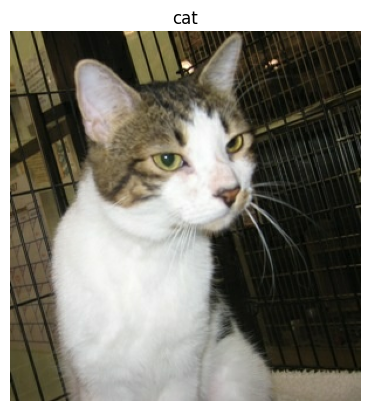

In [43]:
# Let's visualize the image from the previous cell
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis("off")
plt.show()

In [44]:
# With the sample analyses we learned that the data images requires preprocessing
# The images need to be resized to be all the same size, rescaled to be 0-1, and we can also cast them to float32
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)
    return image, label

In [46]:
# Visualize the preprocessed image with the same steps as before
preprocessed_image, label = preprocess_image(image, label)
print(f"Image shape: {preprocessed_image.shape};   Label: {label.numpy()};   Label (str format): {class_names[label.numpy()]}")
print(f"Image dtype: {preprocessed_image.dtype};   Label dtype: {label.dtype}")
print(f"Image min value: {tf.reduce_min(preprocessed_image).numpy()};   Image max value: {tf.reduce_max(preprocessed_image).numpy()}")
print(preprocessed_image.numpy())

Image shape: (224, 224, 3);   Label: 0;   Label (str format): cat
Image dtype: <dtype: 'float32'>;   Label dtype: <dtype: 'int64'>
Image min value: 0.0;   Image max value: 1.0
[[[8.44284594e-02 7.33290240e-02 1.05248345e-02]
  [2.27014557e-01 2.13184014e-01 1.16772011e-01]
  [4.98745173e-01 4.79137301e-01 3.29593092e-01]
  ...
  [1.80376694e-01 1.22919314e-01 4.84095141e-02]
  [2.45718643e-01 1.83834404e-01 1.07003279e-01]
  [2.68435150e-01 2.03379154e-01 1.24142453e-01]]

 [[1.69464350e-01 1.60371035e-01 8.82399827e-02]
  [1.54415205e-01 1.40584663e-01 5.66129535e-02]
  [4.76931721e-01 4.55274642e-01 3.15482140e-01]
  ...
  [2.22070158e-01 1.74731165e-01 9.81721207e-02]
  [2.46888384e-01 1.92896798e-01 1.16908222e-01]
  [2.51845479e-01 1.97853893e-01 1.20332882e-01]]

 [[3.55844200e-01 3.46583307e-01 2.52481610e-01]
  [9.86469537e-02 7.89690837e-02 2.57914711e-04]
  [4.03581470e-01 3.79962981e-01 2.60819972e-01]
  ...
  [2.23869413e-01 1.90847978e-01 1.15847945e-01]
  [1.89450175e-01 

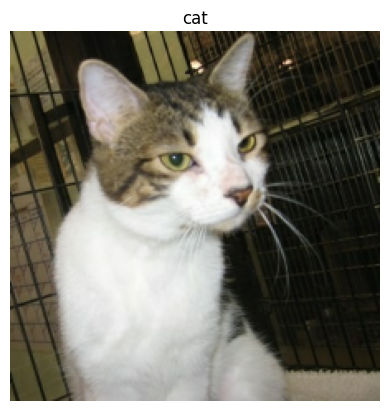

In [47]:
# And visualize the image
plt.imshow(preprocessed_image)
plt.title(class_names[label.numpy()])
plt.axis("off")
plt.show()

In [48]:
# Time to prepare our data for modelling
train_dataset = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
print(train_dataset)
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [50]:
# Setup mixed-precision to speed up the training
mixed_precision.set_global_policy(policy="mixed_float16")
print(mixed_precision.global_policy())

<Policy "mixed_float16">


In [51]:
# Build model
# We will be using transfer learning
base_model = tf.keras.applications.MobileNetV3Small(include_top=False, include_preprocessing=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(1, name="output_layer")(x)
outputs = layers.Activation("sigmoid", dtype=tf.float32)(x) # Separate due to mixed precision
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="model")

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [52]:
# Check our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, None, None, 576)   939120    
 al)                                                             
                                                                 
 pooling_layer (GlobalAvera  (None, 576)               0         
 gePooling2D)                                                    
                                                                 
 output_layer (Dense)        (None, 1)                 577       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 939697 (3.58 MB)
Trainable params: 577 (2.25 KB

In [54]:
# Check which layers are using mixed precision
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
MobilenetV3small False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
activation_1 True float32 <Policy "float32">


In [55]:
# Fit the model
history = model.fit(train_dataset,
                    epochs=20,
                    verbose=1,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=2,
                                                                restore_best_weights=True)])

Epoch 1/20
  6/582 [..............................] - ETA: 18s - loss: 0.7757 - accuracy: 0.5208

I0000 00:00:1717243154.186192    5673 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


582/582 [==============================] - 26s 36ms/step - loss: 0.1555 - accuracy: 0.9423 - val_loss: 0.0975 - val_accuracy: 0.9620
Epoch 2/20
582/582 [==============================] - 20s 34ms/step - loss: 0.0907 - accuracy: 0.9652 - val_loss: 0.0863 - val_accuracy: 0.9671
Epoch 3/20
582/582 [==============================] - 19s 32ms/step - loss: 0.0819 - accuracy: 0.9677 - val_loss: 0.0824 - val_accuracy: 0.9695
Epoch 4/20
582/582 [==============================] - 19s 33ms/step - loss: 0.0775 - accuracy: 0.9695 - val_loss: 0.0802 - val_accuracy: 0.9703
Epoch 5/20
582/582 [==============================] - 19s 33ms/step - loss: 0.0745 - accuracy: 0.9706 - val_loss: 0.0790 - val_accuracy: 0.9708
Epoch 6/20
582/582 [==============================] - 19s 32ms/step - loss: 0.0722 - accuracy: 0.9717 - val_loss: 0.0769 - val_accuracy: 0.9727
Epoch 7/20
582/582 [==============================] - 19s 33ms/step - loss: 0.0704 - accuracy: 0.9721 - val_loss: 0.0769 - val_accuracy: 0.9725
Epo

In [56]:
# Evaluate model
test_loss, test_val = model.evaluate(val_dataset)
print(f"Loss: {test_loss} Accuracy: {test_val}")

146/146 [==============================] - 4s 25ms/step - loss: 0.0751 - accuracy: 0.9727
Loss: 0.0751023069024086 Accuracy: 0.9726999402046204


In [57]:
# Save model
save_dir = "mobinetnet_cats_vs_dogs.keras"
model.save(save_dir)

In [58]:
# Load model to ensure it saved properly
save_dir = "mobinetnet_cats_vs_dogs.keras"
loaded_model = tf.keras.models.load_model(save_dir)
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, None, None, 576)   939120    
 al)                                                             
                                                                 
 pooling_layer (GlobalAvera  (None, 576)               0         
 gePooling2D)                                                    
                                                                 
 output_layer (Dense)        (None, 1)                 577       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 939697 (3.58 MB)
Trainable params: 577 (2.25 KB

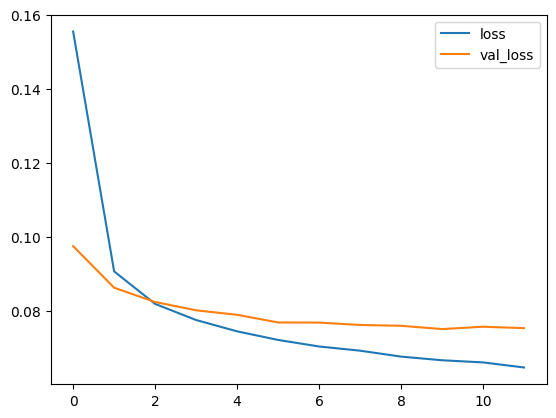

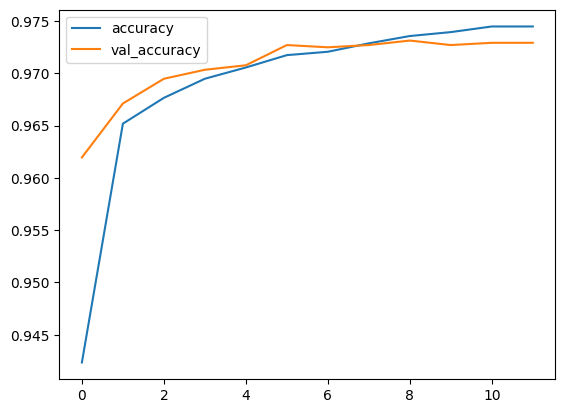

In [59]:
# Check training curves
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()
plt.show()

In [60]:
# Make a function to classify our own images
def classify_image(model, image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255., tf.float32)
    image_expanded = tf.expand_dims(image, axis=0)
    prediction = int(round(tf.squeeze(model.predict(image_expanded, verbose=0)).numpy()))
    return image, prediction

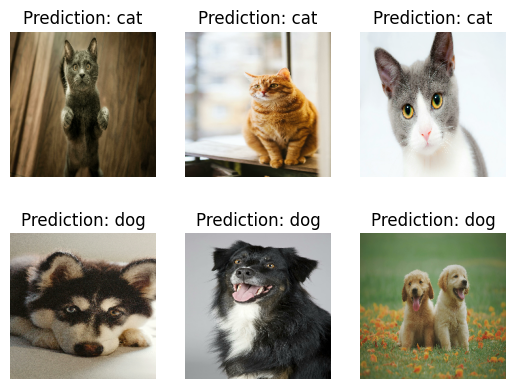

In [61]:
# Classify our images
images_list = "images/cat1.jpg", "images/cat2.jpg", "images/cat3.jpg", "images/dog1.jpg", "images/dog2.jpg", "images/dog3.jpg"
plt.figure()
for i, image_path in enumerate(images_list):
    image, prediction = classify_image(loaded_model, image_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title(f"Prediction: {class_names[prediction]}")
    plt.axis(False);
plt.show()